<a href="https://colab.research.google.com/github/JanChocyk/Face_in_the_window/blob/master/human_face_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Owerview
In this notebook, I build, train and test my own model that classifies the human face for use in the game "Face in the window".

I will use a pre-trained model and transfer learning technique to get a classifier for the problem of recognizing two categories: human face or something else.

I'll load the model from TF Hub, then add an output layer appropriate to our problem. Then I will train the model on the previously prepared dataset.

Let's start!

### Imports

In [1]:
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
import os
print(f'Tensorflow version: {tf.__version__}')
print(f'Tensorflow Hub version: {hub.__version__}')

Tensorflow version: 2.12.0
Tensorflow Hub version: 0.14.0


### Prepare data and augmentation


In [ ]:
data_train_dir = "/content/drive/MyDrive/Colab Notebooks/face_in_the_window/data/data_train"
data_test_dir = "/content/drive/MyDrive/Colab Notebooks/face_in_the_window/data/data_test"


In [ ]:
IMG_SIZE = 224

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

Found 4637 files belonging to 2 classes.
Using 3710 files for training.
Found 4637 files belonging to 2 classes.
Using 927 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['face', 'no_face']


### Prepare Model
- load pre-trainned model
- set output layer
- compile and summary model

In [ ]:
feature_extractor_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
IMAGE_SHAPE = (224, 224)

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_url,
    input_shape=IMAGE_SHAPE+(3,)
)

# zamrażamy wagi ekstraktora
feature_extractor_layer.trainable = False

In [ ]:
# budujemy model dokładając ostatnią warstwę klasyfikacji
model = tf.keras.Sequential([
  normalization_layer,
  data_augmentation,
  feature_extractor_layer,
  tf.keras.layers.Dense(2, activation='softmax')
])

model.build([None, 224, 224, 3])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


### Traning model

In [ ]:
epochs = 1
dt = datetime.now().strftime('%d_%m_%Y_%H_%M')
output_dir = '/content/drive/MyDrive/Colab Notebooks/face_in_the_window/output'

# Zapisz model w formacie TensorFlow SavedModel przy użyciu ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(output_dir, 'best_model_', dt),  # Folder zapisu modelu
    monitor='val_accuracy',
    save_best_only=True,
    save_format='tf'  # Zapisz w formacie SavedModel
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks = [checkpoint])

116/116 [==============================] - 1464s 13s/step - loss: 0.0783 - accuracy: 0.9763 - val_loss: 0.0636 - val_accuracy: 0.9795


### Visualization training process

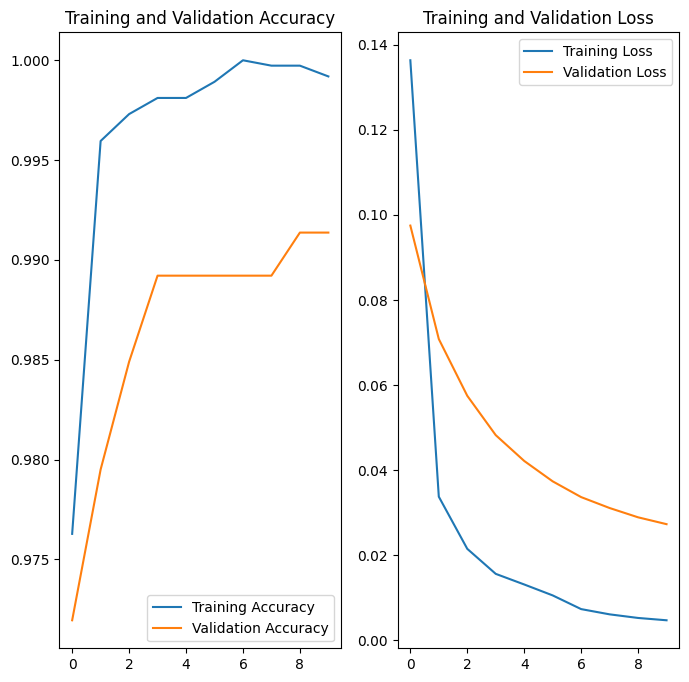

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluation and prodiction

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

Found 463 files belonging to 2 classes.
15/15 [==============================] - 27s 764ms/step - loss: 0.0164 - accuracy: 1.0000
Test accuracy : 1.0


### Test Clasiffication

In [3]:
import cv2

model_path = '/content/drive/MyDrive/Colab Notebooks/face_in_the_window/output/best_model_/28_08_2023_11_14'

loaded_model = tf.keras.models.load_model(model_path)

input_image = '/content/COCO_train2014_000000000078.jpg'

image_array = cv2.imread(input_image)
image_array = cv2.resize(image_array, (224, 224))

# Przygotowanie jednego przykładu obrazu
image_array = tf.expand_dims(image_array, 0)

predictions = loaded_model.predict(image_array)
print(predictions)

1/1 [==============================] - 8s 8s/step
[[0.03363881 0.9663612 ]]


In [5]:
input_image = '/content/COCO_train2014_000000000322.jpg'

image_array = cv2.imread(input_image)
image_array = cv2.resize(image_array, (224, 224))


# Przygotowanie jednego przykładu obrazu
image_array = tf.expand_dims(image_array, 0)

predictions = loaded_model.predict(image_array)
print(predictions)

1/1 [==============================] - 0s 26ms/step
[[0.00307818 0.99692184]]
